# Klasifikasi Gambar Rempah-Rempah Indonesia

- Nama : Fiyanda Ma'muri
- Deskripsi : Membuat model untuk klasifikasi gambar dengan arsitektur MobileNetv2 + Feature Extraction untuk web klasifikasi rempah sebagai proyek skripsi.

## import library

In [18]:
import os
import pandas as pd
import numpy as np
import shutil
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
import json

## import datasets

In [2]:
image_data = 'datasets'

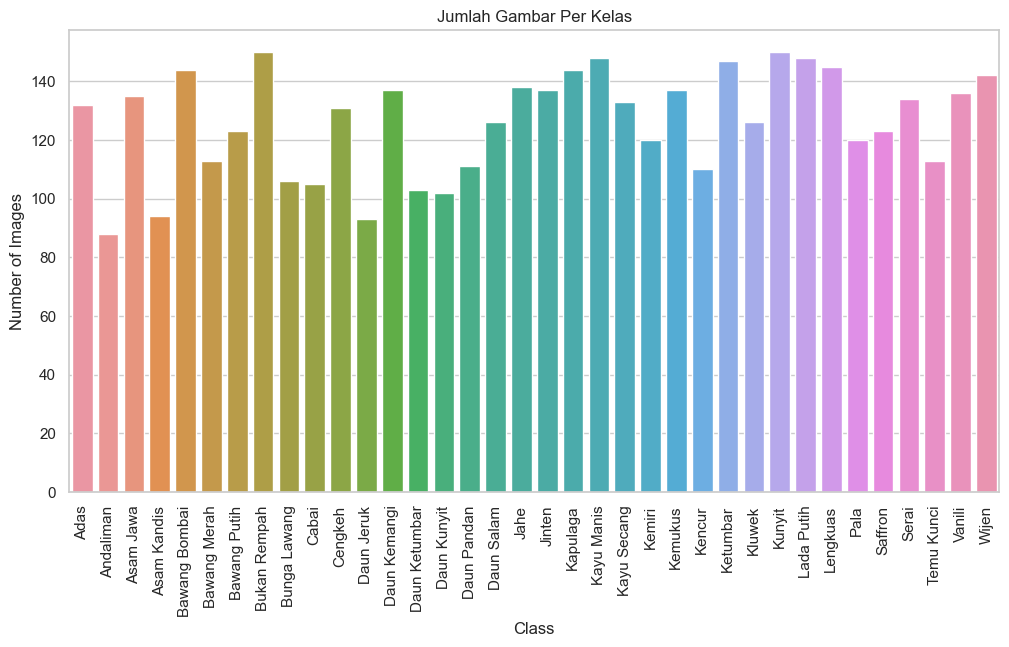

In [3]:
# Menghitung jumlah gambar di setiap kelas (folder)
class_counts = []
class_names = []

for class_name in os.listdir(image_data):
    class_path = os.path.join(image_data, class_name)
    if os.path.isdir(class_path): 
        num_images = len(os.listdir(class_path))
        class_counts.append(num_images)
        class_names.append(class_name)

df = pd.DataFrame({'Class': class_names, 'Count': class_counts})

# Visualisasi dengan seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="Count", data=df)
plt.xticks(rotation=90)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Jumlah Gambar Per Kelas")
plt.show()

In [4]:
df

,Class,Count
0,Adas,132
1,Andaliman,88
2,Asam Jawa,135
3,Asam Kandis,94
4,Bawang Bombai,144
5,Bawang Merah,113
6,Bawang Putih,123
7,Bukan Rempah,150
8,Bunga Lawang,106
9,Cabai,105


## split datasets

In [5]:
def split_dataset(source_dir, train_dir, val_dir, test_dir, train_ratio=0.7, val_ratio=0.15):
    """
    Membagi dataset ke dalam folder Train, Validation, dan Test menggunakan train_test_split dari sklearn.

    Parameters:
    source_dir (str): Path dataset asli.
    train_dir (str): Path untuk dataset training.
    val_dir (str): Path untuk dataset validation.
    test_dir (str): Path untuk dataset testing.
    train_ratio (float): Proporsi data untuk training.
    val_ratio (float): Proporsi data untuk validation.
    """
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    test_ratio = 1.0 - (train_ratio + val_ratio)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        images = [img for img in images if os.path.isfile(os.path.join(class_path, img))]

        # Split train dan sisa
        train_images, temp_images = train_test_split(
            images, test_size=(1 - train_ratio), random_state=42, shuffle=True
        )

        # Split sisa menjadi val dan test
        val_relative_ratio = val_ratio / (val_ratio + test_ratio)
        val_images, test_images = train_test_split(
            temp_images, test_size=(1 - val_relative_ratio), random_state=42, shuffle=True
        )

        for dataset_dir, dataset_images in zip([train_dir, val_dir, test_dir],
                                               [train_images, val_images, test_images]):
            class_dest = os.path.join(dataset_dir, class_name)
            os.makedirs(class_dest, exist_ok=True)

            for img in dataset_images:
                shutil.copy(os.path.join(class_path, img), os.path.join(class_dest, img))

# Path dataset asli dan tujuan
source_dataset = "datasets"
train_dataset = "split-data/Train"
val_dataset = "split-data/Validation"
test_dataset = "split-data/Test"

# Jalankan fungsi split
split_dataset(source_dataset, train_dataset, val_dataset, test_dataset)

## preprocessing data

In [6]:
# Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data dari folder yang telah dibagi
train_generator = train_datagen.flow_from_directory(
    train_dataset,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dataset,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dataset,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 3161 images belonging to 36 classes.
Found 663 images belonging to 36 classes.
Found 720 images belonging to 36 classes.


## modelling

In [10]:
# Memuat model MobileNetV2 tanpa fully connected layers (include_top=False)
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Membekukan semua lapisan MobileNetV2 agar tidak dilatih ulang
base_model.trainable = False

# Membuat model baru dengan lapisan tambahan (feature extraction)
model = Sequential([
    base_model,
    GlobalMaxPooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(36, activation='softmax')
])


# Menyusun model dengan optimizer, loss function, dan metrik evaluasi
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Menampilkan ringkasan model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 36)             │         2,340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,432,548 (9.28 MB)

 Trainable params: 174,564 (681.89 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Custom Callback untuk menghentikan training jika akurasi mencapai 92%
class StopAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_acc=0.90):
        super(StopAtAccuracy, self).__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= self.target_acc:
            print(f"\nTraining dihentikan karena akurasi telah mencapai {logs.get('accuracy'):.2f}")
            self.model.stop_training = True

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
stop_at_acc = StopAtAccuracy(target_acc=0.92)

In [13]:
# Melakukan training
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), StopAtAccuracy()]
)

c:\Users\fiyan\Documents\REMPAH CLASIFICATION\imgvenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 164s 806ms/step - accuracy: 0.0500 - loss: 4.0397 - precision: 0.0869 - recall: 0.0035 - val_accuracy: 0.2036 - val_loss: 3.0278 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 124s 624ms/step - accuracy: 0.1649 - loss: 3.0537 - precision: 0.4097 - recall: 0.0073 - val_accuracy: 0.3786 - val_loss: 2.2361 - val_precision: 0.9000 - val_recall: 0.0543
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 118s 597ms/step - accuracy: 0.2907 - loss: 2.5078 - precision: 0.5993 - recall: 0.0735 - val_accuracy: 0.5234 - val_loss: 1.7201 - val_precision: 0.8413 - val_recall: 0.1599
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 119s 602ms/step - accuracy: 0.3986 - loss: 2.0909 - precision: 0.6623 - recall: 0.1707 - val_accuracy: 0.6410 - val_loss: 1.3948 - val_precision: 0.9005 - val_recall: 0.2866
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 120s 607ms/step - accuracy: 0.4544 - loss: 1.7780 - precision: 0.6812 - recall: 0.2631 - val_acc

## model evaluation

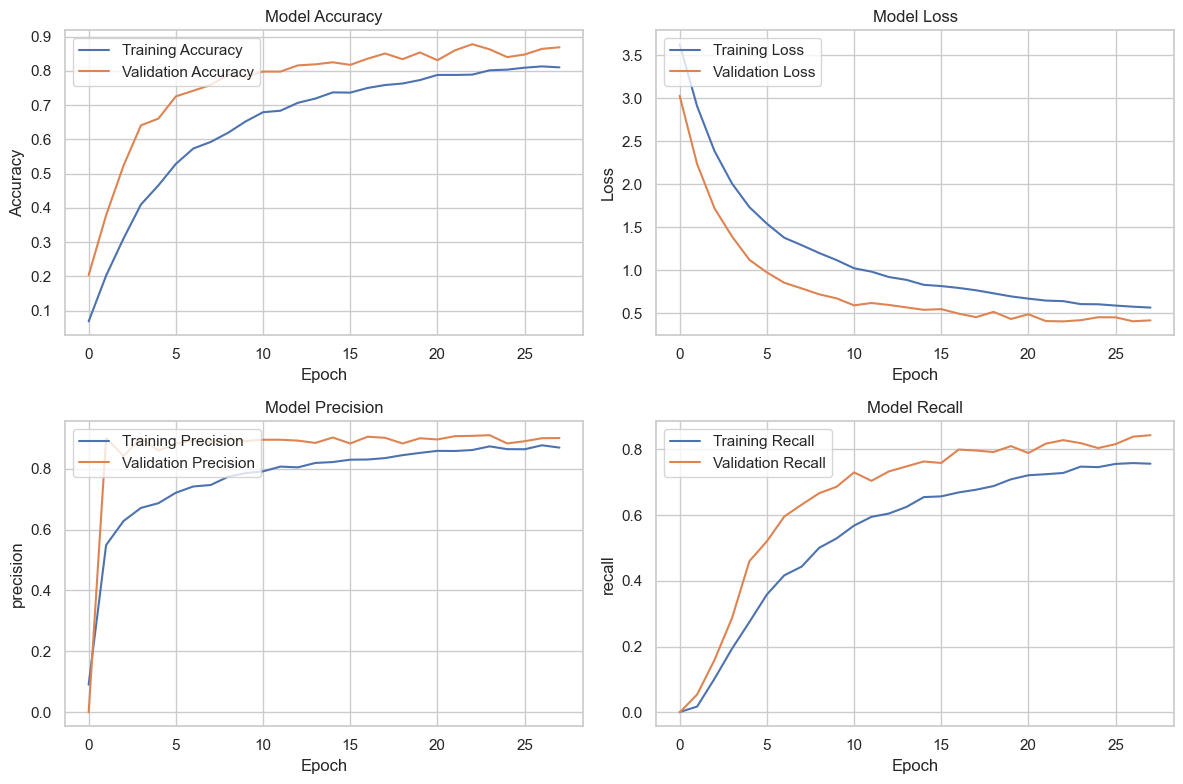

In [14]:
plt.figure(figsize=(12, 8))

# Plot Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot Precision
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.ylabel('precision')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot Recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.ylabel('recall')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

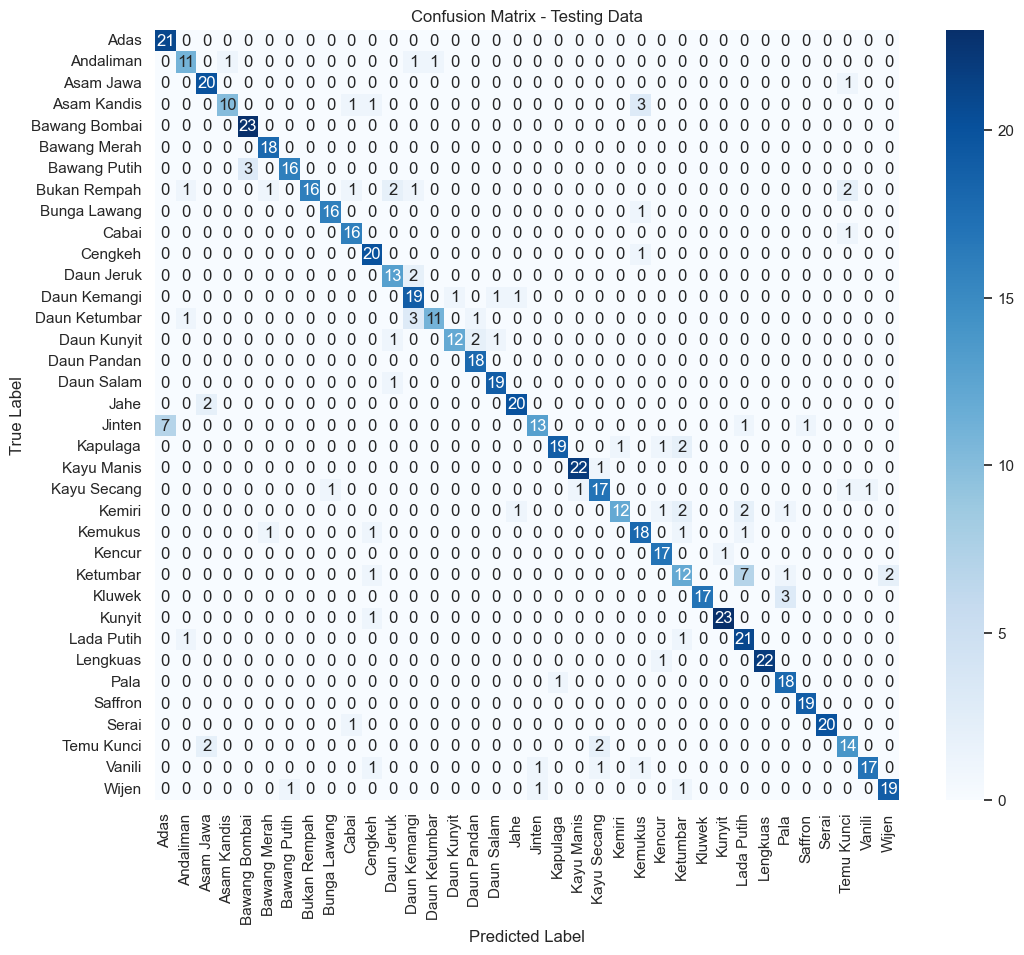


Classification Report (Data Testing):
               precision    recall  f1-score   support

         Adas       0.75      1.00      0.86        21
    Andaliman       0.79      0.79      0.79        14
    Asam Jawa       0.83      0.95      0.89        21
  Asam Kandis       0.91      0.67      0.77        15
Bawang Bombai       0.88      1.00      0.94        23
 Bawang Merah       0.90      1.00      0.95        18
 Bawang Putih       0.94      0.84      0.89        19
 Bukan Rempah       1.00      0.67      0.80        24
 Bunga Lawang       0.94      0.94      0.94        17
        Cabai       0.84      0.94      0.89        17
      Cengkeh       0.80      0.95      0.87        21
   Daun Jeruk       0.76      0.87      0.81        15
 Daun Kemangi       0.73      0.86      0.79        22
Daun Ketumbar       0.92      0.69      0.79        16
  Daun Kunyit       0.92      0.75      0.83        16
  Daun Pandan       0.86      1.00      0.92        18
   Daun Salam       0.90 

In [ ]:
# visualisai confusion matrix
class_labels = list(train_generator.class_indices.keys())

y_true = []
y_pred = []

for images, labels in test_generator:
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

    if len(y_true) >= test_generator.samples:
        break

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Testing Data')
plt.show()

print("\nClassification Report (Data Testing):")
print(classification_report(y_true, y_pred, target_names=class_labels))

## Pre-Deployment

In [ ]:
# Simpan model dalam format TensorFlow (.h5)
model.save('dashboard/model.h5')

In [ ]:
# Simpan class_indices ke file JSON
with open("dashboard/labels.json", "w") as f:
    json.dump(train_generator.class_indices, f)

print("Labels berhasil disimpan!")

Labels berhasil disimpan!
